## MS COCO 데이터를 한글캡셔닝으로 학습시킨 모델 + 멀티모달 데이터 추가활용
## 멀티모달 한글 캡셔닝 전처리 : hanspell(맞춤법) 수정
### 텐서플로우 케라스 토크나이저를 사용하였으며, 세부내용은 아래와 같습니다.

학습 데이터 수 : 147261장(사진), 736582문장(캡션수)<br>
데이터셋 분할 : 훈련 : 검증 : 시험 / 8 : 1 : 1<br>
vocab_size = 27541 / max_length = 58<br>
Batch_size = 64, Buffer_size = 1000, embedding_dim = 256<br>
units = 512 / features_shape = 2048 / attention_features_shape = 64<br>

Epoch 1 : Loss 0.561871 / Loss(val) 1.394192<br>
Epoch 2 : Loss 0.489833 / Loss(val) 1.398128<br>
Epoch 3 : Loss 0.467411 / Loss(val) 1.428955<br>
Epoch 3 : Loss 0.467411 / Loss(val) 1.428955<br>
Epoch 4 : Loss 0.452295 / Loss(val) 1.439146<br>
Epoch 5 : Loss 0.440413 / Loss(val) 1.450918<br>
Epoch 6 : Loss 0.430821 / Loss(val) 1.477073<br>
Epoch 7 : Loss 0.422616 / Loss(val) 1.464120<br>
Epoch 8 : Loss 0.415682 / Loss(val) 1.474477<br>
Epoch 9 : Loss 0.409765 / Loss(val) 1.479583<br>
Epoch 10 : Loss 0.404578 / Loss(val) 1.491735<br>



In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download image files / 모델 테스트용 사진으로 사용하기 위해 다운로드 하는 것이므로 반드시 안하셔도 됩니다.
# 해당 학습모델을 학습시킬때 사용한 데이터 셋이므로 정확도는 높게 나옵니다.
image_folder = '/val014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)

6645022720/6645013297 [==============================] - 138s 0us/step


In [ ]:
# Feel free to change these parameters according to your system's configuration
# 해당 모델에 들어가야하는 필수 변수들이며, 학습시킬때의 수치와 일치화 시켜주었습니다.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 27541
max_length = 58
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
!pip3 install JPype1
!pip3 install konlpy

     |████████████████████████████████| 448 kB 5.0 MB/s 
     |████████████████████████████████| 19.4 MB 5.2 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
df_Tk = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/이미지캡셔닝/Image Captioning(한글모델)/Tensorflow_Keras_T(Okt사용)/tokenizer(word_to_index_Okt).csv')
df_Tk.head()

,word,index
0,pad,0
1,unk,1
2,start,2
3,안경,3
4,을,4


In [ ]:
from tqdm.notebook import tqdm
from konlpy.tag import Okt
tokenizer = Okt()
word_to_index = dict(zip(df_Tk['word'], df_Tk['index']))
index_to_word = dict(zip(df_Tk['index'], df_Tk['word']))
len(word_to_index) ,len(index_to_word)

(27541, 27541)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


## 모델

재미있는 사실: 아래의 디코더는 [Attention을 사용한 신경망 기계 번역](https://www.tensorflow.org/text/tutorials/nmt_with_attention)의 디코더와 동일합니다.

모델 아키텍처는 [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) 논문에서 영감을 얻었습니다.

- 이 예제에서는 InceptionV3의 하위 컨볼루셔널 레이어에서 특성을 추출하여 형상 (8, 8, 2048)의 백터를 제공합니다.
- (64, 2048)의 형상으로 스쿼시합니다.
- 그런 다음, 이 벡터는 CNN Encoder(단일 완전 연결 레이어로 구성)를 통해 전달됩니다.
- RNN(여기서는 GRU)이 다음 단어를 예측하기 위해 이미지를 살펴봅니다.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
# encoder.summary()
# decoder.summary()

In [ ]:
checkpoint_path = '/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/이미지캡셔닝/Image Captioning(한글모델)/Tensorflow_Keras_T(Okt사용)'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50) 
ckpt.restore(ckpt_manager.latest_checkpoint)

## 캡션!

- evaluate 함수는 여기에서 teacher forcing을 사용하지 않는다는 점을 제외하고 훈련 루프와 유사합니다. 각 타임스텝에서 decoder로의 입력은 hidden state 및 encoder 출력과 함께 이전 예측값입니다.
- 모델이 end 토큰을 예측할 때 예측을 중지합니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_input = tf.expand_dims([word_to_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(index_to_word[predicted_id])

        # if tokenizer.index_word[predicted_id] == '<end>':
        #     return result, attention_plot
        if index_to_word[predicted_id] == 'end':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
import os
path_dir = '/content/val2014/'
file_dir = os.listdir(path_dir)
path_dir + file_dir[0]

'/content/val2014/COCO_val2014_000000512467.jpg'

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-bshu84wc
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-bshu84wc
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=c83291094ac9c7d624698002dfddea37b4ecef8c5894f5bf20710abd4faecb36
  Stored in directory: /tmp/pip-ephem-wheel-cache-rsrsu1dr/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
annotation_file = '/content/drive/MyDrive/data/project03/multi/MSCOCO_train_val_Korean.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
annotations

[{'caption_ko': ['빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다.',
   '시골의 비포장 도로에서 오토바이를 타는 남자',
   '오토바이 뒤에 탄 남자',
   '오토바이 위에 젊은이가 탄 비포장 도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 산의 배경이 있다.',
   '빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다.'],
  'captions': ['A man with a red helmet on a small moped on a dirt road. ',
   'Man riding a motor bike on a dirt road on the countryside.',
   'A man riding on the back of a motorcycle.',
   'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
   'A man in a red shirt and a red hat is on a motorcycle on a hill side.'],
  'file_path': 'val2014/COCO_val2014_000000391895.jpg',
  'id': 391895},
 {'caption_ko': ['케이크를 자르고 있는 머리에 그물을 두른 여자',
   '큰 하얀 시트 케이크를 자르고 있는 여자',
   '큰 시트 케이크를 자르고 있는 헤어 네트를 두른 여자',
   '하얀 케이크를 자르고 있는 여자가 있다.',
   '주방장의 칼등으로 케이크를 만드는 여자.'],
  'captions': ['A woman wearing a net on her head cutting a cake. ',
   'A woman cutting a large white sheet cake.',
  

In [ ]:
df = pd.DataFrame(annotations)
df

,file_path,captions,id,caption_ko
0,val2014/COCO_val2014_000000391895.jpg,[A man with a red helmet on a small moped on a...,391895,"[빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다., 시골의 비포장..."
1,val2014/COCO_val2014_000000522418.jpg,[A woman wearing a net on her head cutting a c...,522418,"[케이크를 자르고 있는 머리에 그물을 두른 여자, 큰 하얀 시트 케이크를 자르고 있..."
2,val2014/COCO_val2014_000000184613.jpg,[A child holding a flowered umbrella and petti...,184613,"[꽃이 핀 우산을 들고 북을 치고 있는 아이., 한 젊은 남자가 소떼 옆에 우산을 ..."
3,val2014/COCO_val2014_000000318219.jpg,[A young boy standing in front of a computer k...,318219,"[컴퓨터 키보드 앞에 서 있는 어린 소년, 헤드폰을 끼고 컴퓨터 모니터를 보고 있는..."
4,val2014/COCO_val2014_000000554625.jpg,[a boy wearing headphones using one computer i...,554625,"[긴 컴퓨터 한줄에 헤드폰을 끼고 있는 소년, 이어폰을 끼고 무언가를 듣는 어린 소..."
...,...,...,...,...
123282,train2014/COCO_train2014_000000444010.jpg,[A group of friends sitting down at a table sh...,444010,"[한 무리의 친구들이 식사를 나누어 먹으며 테이블에 앉아 있다., 식당 테이블에 앉..."
123283,train2014/COCO_train2014_000000565004.jpg,"[wine being poured into a glass over a table, ...",565004,"[테이블 위의 유리 컵에 따른 와인, 컵에 적포도주를 따른다., 테이블 위의 유리 ..."
123284,train2014/COCO_train2014_000000516168.jpg,"[A man is standing behind a bar with glases, A...",516168,"[한 남자가 안경을 끼고 바에 서 있다., 와인 잔이 있는 테이블에서 종이를 관찰하..."
123285,train2014/COCO_train2014_000000547503.jpg,[A group of men sitting at a bar having drinks...,547503,"[술집에 앉아 술을 마시고 있는 한 무리의 남자들, 투수 앞에 한 남자가 앉아 있다..."


In [ ]:
df

,file_path,captions,id,caption_ko,type,img
0,val2014/COCO_val2014_000000391895.jpg,[A man with a red helmet on a small moped on a...,391895,"[빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다., 시골의 비포장...",val2014,COCO_val2014_000000457687.jpg
1,val2014/COCO_val2014_000000522418.jpg,[A woman wearing a net on her head cutting a c...,522418,"[케이크를 자르고 있는 머리에 그물을 두른 여자, 큰 하얀 시트 케이크를 자르고 있...",val2014,COCO_val2014_000000457687.jpg
2,val2014/COCO_val2014_000000184613.jpg,[A child holding a flowered umbrella and petti...,184613,"[꽃이 핀 우산을 들고 북을 치고 있는 아이., 한 젊은 남자가 소떼 옆에 우산을 ...",val2014,COCO_val2014_000000457687.jpg
3,val2014/COCO_val2014_000000318219.jpg,[A young boy standing in front of a computer k...,318219,"[컴퓨터 키보드 앞에 서 있는 어린 소년, 헤드폰을 끼고 컴퓨터 모니터를 보고 있는...",val2014,COCO_val2014_000000457687.jpg
4,val2014/COCO_val2014_000000554625.jpg,[a boy wearing headphones using one computer i...,554625,"[긴 컴퓨터 한줄에 헤드폰을 끼고 있는 소년, 이어폰을 끼고 무언가를 듣는 어린 소...",val2014,COCO_val2014_000000457687.jpg
...,...,...,...,...,...,...
123282,train2014/COCO_train2014_000000444010.jpg,[A group of friends sitting down at a table sh...,444010,"[한 무리의 친구들이 식사를 나누어 먹으며 테이블에 앉아 있다., 식당 테이블에 앉...",val2014,COCO_val2014_000000457687.jpg
123283,train2014/COCO_train2014_000000565004.jpg,"[wine being poured into a glass over a table, ...",565004,"[테이블 위의 유리 컵에 따른 와인, 컵에 적포도주를 따른다., 테이블 위의 유리 ...",val2014,COCO_val2014_000000457687.jpg
123284,train2014/COCO_train2014_000000516168.jpg,"[A man is standing behind a bar with glases, A...",516168,"[한 남자가 안경을 끼고 바에 서 있다., 와인 잔이 있는 테이블에서 종이를 관찰하...",val2014,COCO_val2014_000000457687.jpg
123285,train2014/COCO_train2014_000000547503.jpg,[A group of men sitting at a bar having drinks...,547503,"[술집에 앉아 술을 마시고 있는 한 무리의 남자들, 투수 앞에 한 남자가 앉아 있다...",val2014,COCO_val2014_000000457687.jpg


In [ ]:
for i in tqdm(range(len(df))):
  df['type'][i]  = df['file_path'][i].split('/')[0]
  df['img'][i] = df['file_path'][i].split('/')[1]
df

  0%|          | 0/123287 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,file_path,captions,id,caption_ko,type,img
0,val2014/COCO_val2014_000000391895.jpg,[A man with a red helmet on a small moped on a...,391895,"[빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다., 시골의 비포장...",val2014,COCO_val2014_000000391895.jpg
1,val2014/COCO_val2014_000000522418.jpg,[A woman wearing a net on her head cutting a c...,522418,"[케이크를 자르고 있는 머리에 그물을 두른 여자, 큰 하얀 시트 케이크를 자르고 있...",val2014,COCO_val2014_000000522418.jpg
2,val2014/COCO_val2014_000000184613.jpg,[A child holding a flowered umbrella and petti...,184613,"[꽃이 핀 우산을 들고 북을 치고 있는 아이., 한 젊은 남자가 소떼 옆에 우산을 ...",val2014,COCO_val2014_000000184613.jpg
3,val2014/COCO_val2014_000000318219.jpg,[A young boy standing in front of a computer k...,318219,"[컴퓨터 키보드 앞에 서 있는 어린 소년, 헤드폰을 끼고 컴퓨터 모니터를 보고 있는...",val2014,COCO_val2014_000000318219.jpg
4,val2014/COCO_val2014_000000554625.jpg,[a boy wearing headphones using one computer i...,554625,"[긴 컴퓨터 한줄에 헤드폰을 끼고 있는 소년, 이어폰을 끼고 무언가를 듣는 어린 소...",val2014,COCO_val2014_000000554625.jpg
...,...,...,...,...,...,...
123282,train2014/COCO_train2014_000000444010.jpg,[A group of friends sitting down at a table sh...,444010,"[한 무리의 친구들이 식사를 나누어 먹으며 테이블에 앉아 있다., 식당 테이블에 앉...",train2014,COCO_train2014_000000444010.jpg
123283,train2014/COCO_train2014_000000565004.jpg,"[wine being poured into a glass over a table, ...",565004,"[테이블 위의 유리 컵에 따른 와인, 컵에 적포도주를 따른다., 테이블 위의 유리 ...",train2014,COCO_train2014_000000565004.jpg
123284,train2014/COCO_train2014_000000516168.jpg,"[A man is standing behind a bar with glases, A...",516168,"[한 남자가 안경을 끼고 바에 서 있다., 와인 잔이 있는 테이블에서 종이를 관찰하...",train2014,COCO_train2014_000000516168.jpg
123285,train2014/COCO_train2014_000000547503.jpg,[A group of men sitting at a bar having drinks...,547503,"[술집에 앉아 술을 마시고 있는 한 무리의 남자들, 투수 앞에 한 남자가 앉아 있다...",train2014,COCO_train2014_000000547503.jpg


In [ ]:
df2 = df[df['type']=='val2014']
df2 = df2[['img', 'caption_ko']]
df2

,img,caption_ko
0,COCO_val2014_000000391895.jpg,"[빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다., 시골의 비포장..."
1,COCO_val2014_000000522418.jpg,"[케이크를 자르고 있는 머리에 그물을 두른 여자, 큰 하얀 시트 케이크를 자르고 있..."
2,COCO_val2014_000000184613.jpg,"[꽃이 핀 우산을 들고 북을 치고 있는 아이., 한 젊은 남자가 소떼 옆에 우산을 ..."
3,COCO_val2014_000000318219.jpg,"[컴퓨터 키보드 앞에 서 있는 어린 소년, 헤드폰을 끼고 컴퓨터 모니터를 보고 있는..."
4,COCO_val2014_000000554625.jpg,"[긴 컴퓨터 한줄에 헤드폰을 끼고 있는 소년, 이어폰을 끼고 무언가를 듣는 어린 소..."
...,...,...
40499,COCO_val2014_000000134574.jpg,"[식탁 위에 음식을 담은 접시 네개가 놓여 있다., 식품과 컵이 테이블 위에 있는 ..."
40500,COCO_val2014_000000572233.jpg,"[사람들이 피로연을 위해 테이블에 앉아 있다., 테이블에 앉아 있는 많은 사람들이 ..."
40501,COCO_val2014_000000418825.jpg,"[과일과 야채는 식사를 준비하기 위해 조리대 위에 놓여 있다., 탁자 위에 토마토가..."
40502,COCO_val2014_000000560744.jpg,"[두명의 여자와 한명의 남자가 테이블에 앉아 있는 그룹., 저녁 식탁에서 두명의 여..."


In [ ]:
testcap = df2.loc[0]['caption_ko']
testcap = str(testcap).strip("['']'")
testcap

"빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다.', '시골의 비포장 도로에서 오토바이를 타는 남자', '오토바이 뒤에 탄 남자', '오토바이 위에 젊은이가 탄 비포장 도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 산의 배경이 있다.', '빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다."

In [ ]:
testcap2 = list(testcap.split(','))
testcap2

["빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다.'",
 " '시골의 비포장 도로에서 오토바이를 타는 남자'",
 " '오토바이 뒤에 탄 남자'",
 " '오토바이 위에 젊은이가 탄 비포장 도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 산의 배경이 있다.'",
 " '빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다."]

In [ ]:
test = '/content/val2014/'

In [ ]:
test_img = os.listdir(test)

COCO_val2014_000000512467.jpg
예측문장1: 검은색 흰색과 검은색 개 가 들판에서 풀 을 뜯고 있는 큰 갈색과 흰색 말
예측문장2: 풀밭에 서 있는 말
예측문장3: 초원 위에서 풀 을 뜯고 있다
예측문장4: 푸른 초원에 앉아 있다
예측문장5: 검은색과 검은색 말 이 들판을 가로질러 걷고 있다
정답문장1: 무성한 초록 들판에 서 있는 키 크고 검고 하얀 말
정답문장2: 큰 검고 하얀 말은 긴 털을 가지고 있다.
정답문장3: 하얀 말과 검은 말이 뒤에 나무가 있는 풀밭에서 풀을 뜯고 있다.
정답문장4: 말이 풀을 먹으며 허리를 굽히고 있을 때.
정답문장5: 푸른 들판에서 풀을 뜯고 있는 말


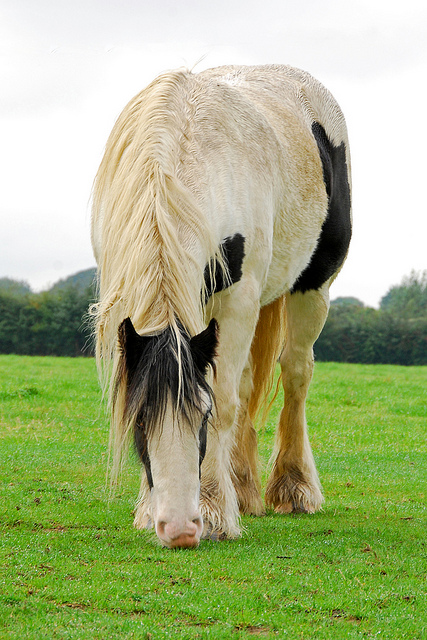

In [ ]:
from hanspell import spell_checker
import random 
i = random.randint(0, len(file_dir))
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-3:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = test_img[0]
# image_path = path_dir + file_dir[i]
print(image_path)

prediction_list = []
for i in range(5):
  result, attention_plot = evaluate(test+image_path)
  caption = ' '.join(result)
  caption = caption.replace(' end', '')
  spelled_check = spell_checker.check(caption)
  print(f'예측문장{i+1}:', spelled_check.checked)
  # print(f'원래문장{i+1}:', ' '.join(result))
  prediction_list.append(spelled_check.checked)
import re
x = df2[df2['img'] == image_path]['caption_ko']
x = list(x)
x = str(x).strip("[]").replace(" '", '').replace("'", '')
x= x.split(',')
i = []
for z , xx in enumerate(x):
  i.append(xx)
  print(f'정답문장{z+1}:', xx)
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(test+image_path)

# BLEU Score 계산

In [ ]:
prediction_list

['검은색 흰색과 검은색 개 가 들판에서 풀 을 뜯고 있는 큰 갈색과 흰색 말',
 '풀밭에 서 있는 말',
 '초원 위에서 풀 을 뜯고 있다',
 '푸른 초원에 앉아 있다',
 '검은색과 검은색 말 이 들판을 가로질러 걷고 있다']

In [ ]:
i

['무성한 초록 들판에 서 있는 키 크고 검고 하얀 말',
 '큰 검고 하얀 말은 긴 털을 가지고 있다.',
 '하얀 말과 검은 말이 뒤에 나무가 있는 풀밭에서 풀을 뜯고 있다.',
 '말이 풀을 먹으며 허리를 굽히고 있을 때.',
 '푸른 들판에서 풀을 뜯고 있는 말']

* ref : http://incredible.ai/nlp/2020/02/29/BLEU/
* sentence_bleu, 1-Gram BLEU 출력

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

# reference = ['i took a hard test yesterday', 'yesterday i took a trcky test']
# reference = [s.split(' ') for s in reference]
# candidate = 'i took a difficult test yesterday'.split(' ')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

def print_bleu(reference, candidate):
  bleu_sentence = sentence_bleu(reference, candidate)

  bleu_1gram = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  # bleu_2gram = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
  # bleu_3gram = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
  # bleu_4gram = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))

  print(f'reference: {reference}')
  print(f'candidate: {candidate}')
  print(f'sentence_bleu: {bleu_sentence}')
  print(f'1-Gram BLEU: {bleu_1gram:.2f}')
  print()
  # print(f'2-Gram BLEU: {bleu_2gram:.2f}') 1.00 출력
  # print(f'3-Gram BLEU: {bleu_3gram:.2f}') 1.00 출력
  # print(f'4-Gram BLEU: {bleu_4gram:.2f}') 1.00 출력

In [ ]:
# candidates = ['검은색 흰색과 검은색 개 가 들판에서 풀 을 뜯고 있는 큰 갈색과 흰색 말',
#  '풀밭에 서 있는 말',
#  '초원 위에서 풀 을 뜯고 있다',
#  '푸른 초원에 앉아 있다',
#  '검은색과 검은색 말 이 들판을 가로질러 걷고 있다']

# references = ['무성한 초록 들판에 서 있는 키 크고 검고 하얀 말',
#  '큰 검고 하얀 말은 긴 털을 가지고 있다.',
#  '하얀 말과 검은 말이 뒤에 나무가 있는 풀밭에서 풀을 뜯고 있다.',
#  '말이 풀을 먹으며 허리를 굽히고 있을 때.',
#  '푸른 들판에서 풀을 뜯고 있는 말']

In [ ]:
for reference in range(i):
  for candidate in range(prediction_list):
    print_bleu(reference, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


reference: 무성한 초록 들판에 서 있는 키 크고 검고 하얀 말
candidate: 검은색 흰색과 검은색 개 가 들판에서 풀 을 뜯고 있는 큰 갈색과 흰색 말
sentence_bleu: 0.7027551482022703
1-Gram BLEU: 0.24

reference: 무성한 초록 들판에 서 있는 키 크고 검고 하얀 말
candidate: 풀밭에 서 있는 말
sentence_bleu: 0.8801117367933934
1-Gram BLEU: 0.60

reference: 무성한 초록 들판에 서 있는 키 크고 검고 하얀 말
candidate: 초원 위에서 풀 을 뜯고 있다
sentence_bleu: 0.7825422900366437
1-Gram BLEU: 0.38

reference: 무성한 초록 들판에 서 있는 키 크고 검고 하얀 말
candidate: 푸른 초원에 앉아 있다
sentence_bleu: 0.7598356856515925
1-Gram BLEU: 0.33

reference: 무성한 초록 들판에 서 있는 키 크고 검고 하얀 말
candidate: 검은색과 검은색 말 이 들판을 가로질러 걷고 있다
sentence_bleu: 0.7135650476426908
1-Gram BLEU: 0.26

reference: 큰 검고 하얀 말은 긴 털을 가지고 있다.
candidate: 검은색 흰색과 검은색 개 가 들판에서 풀 을 뜯고 있는 큰 갈색과 흰색 말
sentence_bleu: 0.6844861471686758
1-Gram BLEU: 0.22

reference: 큰 검고 하얀 말은 긴 털을 가지고 있다.
candidate: 풀밭에 서 있는 말
sentence_bleu: 0.7400828044922853
1-Gram BLEU: 0.30

reference: 큰 검고 하얀 말은 긴 털을 가지고 있다.
candidate: 초원 위에서 풀 을 뜯고 있다
sentence_bleu: 0.7476743906106103
1-Gram BLEU: 0.31

re

In [ ]:
!pip install pycocoevalcap

     |████████████████████████████████| 104.3 MB 41 kB/s 


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu

In [ ]:
predictions = []
answers = []
answers_per_image = []

total_step = len(test_data_loader)
cnt = 0

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_data_loader):
        images = images.to(device)
        captions = captions.to(device)

        # 순전파(forward) 진행
        features = encoder(images)
        sampled_ids_list = decoder.sample(features)

        for index in range(len(images)):
            sampled_ids = sampled_ids_list[index].cpu().numpy()

            # 정답 문장(answer sentences)
            answer = []
            for word_id in captions[index]: # 하나씩 단어 인덱스를 확인하며
                word = vocab.idx2word[word_id.item()] # 단어 문자열로 바꾸어 삽입
                answer.append(word)
                if word == '<end>':
                    break
            answers_per_image.append(answer[1:-1]) # 정답 문장을 삽입 (<sos>과 <eos>는 제외)

            if (cnt + 1) % 5 == 0: # 이미지당 캡션이 5개씩 존재
                answers.append(answers_per_image) # 5개를 한꺼번에 리스트로 삽입
                answers_per_image = []

                # 예측한 문장(predicted sentences)
                prediction = []
                for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
                    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
                    prediction.append(word)
                    if word == '<end>':
                        break
                predictions.append(prediction[1:-1]) # 예측한 문장에 대해서는 1개만 삽입 (<sos>과 <eos>는 제외)
            cnt += 1

        if i % log_step == 0:
            print(f"[ Testing ] Batch size: {i}/{total_step}")

## (KoGPT2-브런치(일기_10289개)

In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 3.1 MB 7.1 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 3.3 MB 26.3 MB/s 
     |████████████████████████████████| 596 kB 61.6 MB/s 
     |████████████████████████████████| 895 kB 45.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 290 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
     |████████████████████████████████| 243 kB 53.2 MB/s 
     |████████████████████████████████| 132 kB 70.1 MB/s 
     |████████████████████████████████| 160 kB 52.9 MB/s 
     |████████████████████████████████| 192 kB 27.3 MB/s 
     |████████████████████████████████| 271 kB 47.9 MB/s 


In [ ]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
from tqdm.notebook import tqdm

def load_model(model_path):
  model = GPT2LMHeadModel.from_pretrained(model_path)
  return model

def load_tokenizer(tokenizer_path):
  tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
  return tokenizer

def generate_text(sequence, max_lenth):
  model_path = '/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/gpt/브런치(일기)_모델(KoGPT)/checkpoint-316000'
  model = load_model(model_path)
  tokenizer = load_tokenizer(model_path)
  ids = tokenizer.encode(f'{sequence},', return_tensors = 'pt')
  final_outputs = model.generate(
      ids,
      do_sample = True,
      max_length = max_length,
      pad_token_id = model.config.pad_token_id,
      tok_k = 5, # 가장 높은 확률을 지닌 n개의 단어수 중에서 추출
      top_p = 0.90, # 누적확률이 n%인 단어까지 포함하여 그 중에서 추출
      repetition_penalty = 1.5, # 단어사용 반복에 대한 패널티 부여
  )
  return tokenizer.decode(final_outputs[0])

In [ ]:
sequence = prediction_list[0]
max_length = 128
sentence_list = []
# sentence_list.append(generate_text(sequence, max_length))
sentence = generate_text(sequence, max_length)

In [ ]:
ch_sentence = sentence.split(sequence + ', ')[1]
print(f'입력값 : {sequence}')
ch_sentence = ch_sentence.replace('.', '. ')
ch_sentence = ch_sentence.replace('\n', ' ')
ch_sentence = ch_sentence.replace('\"', ' ')
ch_sentence = ch_sentence.replace('  ', ' ')
ch_sentence = ch_sentence.replace('  ', ' ')
ch_sentence = ch_sentence.replace('  ', ' ')
ch_sentence = ch_sentence.replace('. ', '.\n')
print(ch_sentence)

입력값 : 휴대 전화를 타이핑을 하고 있다
그런데 당최 뭘 어떻게 해야 할지 모르겠다.
그러고 보니 요즘엔 노래를 안 들으려고 노력한다.
확실히 예전보다 노래에 관심을 가지게 된 건 다른 세계의 일인 것 같다.
직장인이 되었다는 것은 때론 거대한 일이 벌어지는 것처럼 느껴질 때가 많았는데, 굳이 돌이켜 보자면, 이직을 하겠다는 마음을 먹었거나, 방향을 정했거나 그럴싸한 길을 가겠다고 마음먹은 것에 불과하다.
어쩌면 그런 것만같은 이유들의 결과일지도 모르지만, 내가 다녔던 직장에서는 유독 사람들과 대화하는 게 더 귀찮았다.
심지어 일과 관련된 대화도 거의 단절되었다.
물론 연락을
